In [1]:
import numpy as np
import cv2
import mediapipe as mp
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import multimodel
from multimodel import MultiModelDetector, Behavior_Information

def split_X(X: pd.core.frame.DataFrame):
    return X.iloc[:, :15], X.iloc[:, 15:30], X.iloc[:, 30:46], X.iloc[:, 46:62], X.iloc[:, 62:74], X.iloc[:, 74:76]

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
sns.set(style='white')

In [2]:
def make_model(behavior_int):
    # 입력 레이어 정의
    inputs1 = Input(shape=(15,))
    inputs2 = Input(shape=(15,))
    inputs3 = Input(shape=(16,))
    inputs4 = Input(shape=(16,))
    inputs5 = Input(shape=(12,))
    inputs6 = Input(shape=(2,))
    
    # 모델 브랜치 정의
    # # 브랜치 1
    # x1 = Dense(64, activation='relu')(inputs1)
    # x1 = Dense(32, activation='relu')(x1)
    
    # # 브랜치 2
    # x2 = Dense(64, activation='relu')(inputs2)
    # x2 = Dense(32, activation='relu')(x2)
    
    # # 브랜치 3
    # x3 = Dense(64, activation='relu')(inputs3)
    # x3 = Dense(32, activation='relu')(x3)
    
    # # 브랜치 4
    # x4 = Dense(64, activation='relu')(inputs4)
    # x4 = Dense(32, activation='relu')(x4)
    
    # # 브랜치 5
    # x5 = Dense(64, activation='relu')(inputs5)
    # x5 = Dense(32, activation='relu')(x5)

    if behavior_int == 0:
        merged = concatenate([inputs1, inputs2, inputs3, inputs4, inputs5])
    elif behavior_int == 1:
        merged = concatenate([inputs3, inputs5])
    elif behavior_int == 2:
        merged = concatenate([inputs3, inputs5])    
    elif behavior_int == 3:
        merged = concatenate([inputs1, inputs2, inputs4, inputs6])    
    elif behavior_int == 4:
        merged = concatenate([inputs1, inputs2])
    
    # 출력 레이어 정의
    x = Dense(128, activation='relu')(merged)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # 모델 생성
    model = Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5, inputs6], outputs=outputs)
    
    # 컴파일
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def model_fit(model, X_test, y_test, X_val, y_val, behavior='all', epochs=100):
    model_path = f'models/{behavior}_model{model_version}.keras'

    # 기존 모델 파일이 존재한다면 삭제
    if os.path.exists(model_path):
        os.remove(model_path)
        print(f"기존 모델 파일 '{model_path}' 삭제됨")
    history = model.fit(split_X(X_train),
                        y_train,
                        validation_data=(split_X(X_val), y_val),
                        epochs=epochs,
                        verbose=0,
                        callbacks=[ModelCheckpoint(model_path, 
                                                   monitor='val_accuracy', verbose=0, 
                                                   save_best_only=True, mode='auto'),
                                   ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, 
                                                     verbose=0, mode='auto'),
                                   EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='auto')])
    return history

def plot_show(history):
    fig, loss_ax = plt.subplots(figsize=(16, 10))
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')
    
    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='lower left')
    
    plt.show()

def show_confusion_matrix(beahvior, model, X_test, y_test):
    plt.figure(figsize=(8, 8))
    pred_ys = model.predict(split_X(X_test))

    behaviors = Behavior_Information(behavior).behaviors
                        
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_ys, axis=-1))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=behaviors, 
                yticklabels=behaviors)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    

### small version

#### total

In [9]:
csv_directory = 'datasets_processing_data_csvs'

behaviors = multimodel.behaviors
str2int = multimodel.str2int

model_version = input()
for behavior in behaviors:
    if behavior == 'find_image':
        continue
        
    mmd = MultiModelDetector(behavior)
    num_classes = mmd.num_classes

    data = pd.read_csv(os.path.join(csv_directory, f'{behavior}_small_output.csv'))

    X = data.drop(['name', 'label'], axis=1)
    y = data['label']
    y = to_categorical(y, num_classes=num_classes)

    # train:val:test = 70:15:15
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

    model = make_model(str2int[behavior])
    history = model_fit(model, X_test, y_test, X_val, y_val, behavior)
    # plot_show(history)
 
    test_loss, test_accuracy = model.evaluate(split_X(X_test), y_test, verbose=1)
    print(behavior)
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)
    print()

KeyboardInterrupt: Interrupted by user

#### rollhand

In [3]:
csv_directory = 'datasets_processing_data_csvs'

behaviors = multimodel.behaviors
str2int = multimodel.str2int

model_version = '_small'
behavior = 'rollhand'
mmd = MultiModelDetector(behavior)
num_classes = mmd.num_classes

data = pd.read_csv(os.path.join(csv_directory, f'{behavior}_small_output.csv'))

X = data.drop(['name', 'label'], axis=1)
y = data['label']
y = to_categorical(y, num_classes=num_classes)

# train:val:test = 70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

model = make_model(str2int[behavior])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_4 (InputLayer)    │ (None, 12)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 28)                │               0 │ input_layer_2[0][0],       │
│                               │                           │                 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │           3,712 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           8,256 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 32)                │           2,080 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer (InputLayer)      │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 2)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 3)                 │              99 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 14,147 (55.26 KB)

 Trainable params: 14,147 (55.26 KB)

 Non-trainable params: 0 (0.00 B)

기존 모델 파일 'models/rollhand_model_small.keras' 삭제됨


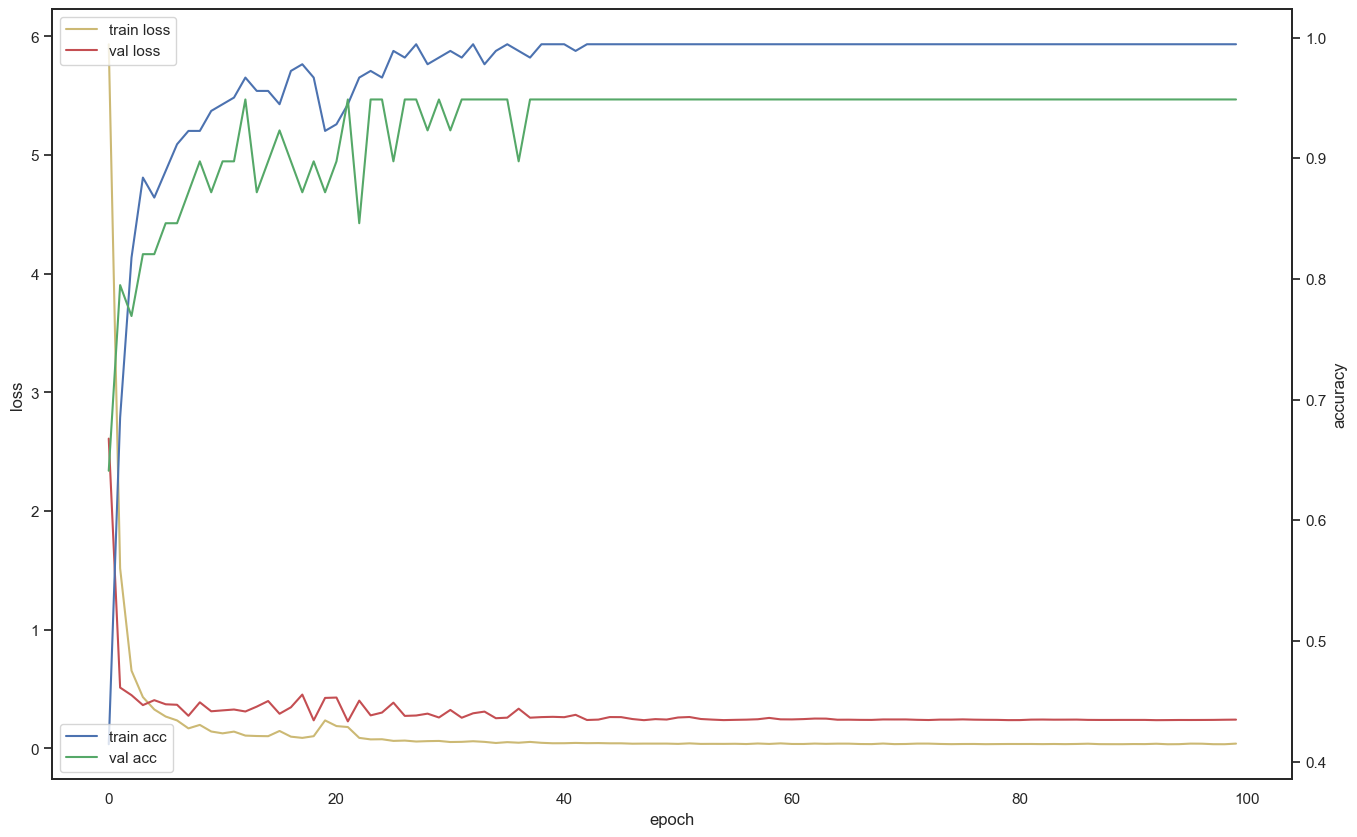

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9175 - loss: 0.2173 
rollhand
Test Loss: 0.17647136747837067
Test Accuracy: 0.9230769276618958



In [4]:
history = model_fit(model, X_test, y_test, X_val, y_val, behavior)
plot_show(history)

test_loss, test_accuracy = model.evaluate(split_X(X_test), y_test, verbose=1)

print(behavior)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


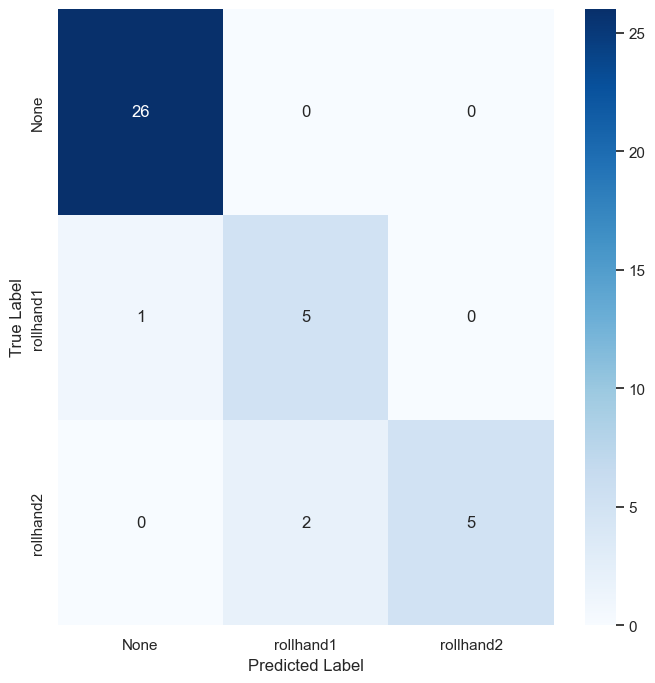

In [5]:
show_confusion_matrix(behavior, model, X_test, y_test)

#### rollfeet

In [6]:
csv_directory = 'datasets_processing_data_csvs'

behaviors = multimodel.behaviors
str2int = multimodel.str2int

model_version = '_small'
behavior = 'rollfeet'
mmd = MultiModelDetector(behavior)
num_classes = mmd.num_classes

data = pd.read_csv(os.path.join(csv_directory, f'{behavior}_small_output.csv'))

X = data.drop(['name', 'label'], axis=1)
y = data['label']
y = to_categorical(y, num_classes=num_classes)

# train:val:test = 70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

model = make_model(str2int[behavior])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)    │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_10 (InputLayer)   │ (None, 12)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 28)                │               0 │ input_layer_8[0][0],       │
│                               │                           │                 │ input_layer_10[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 128)               │           3,712 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 64)                │           8,256 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 32)                │           2,080 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_6 (InputLayer)    │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_7 (InputLayer)    │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_9 (InputLayer)    │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_11 (InputLayer)   │ (None, 2)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 3)                 │              99 │ dense_6[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 14,147 (55.26 KB)

 Trainable params: 14,147 (55.26 KB)

 Non-trainable params: 0 (0.00 B)

기존 모델 파일 'models/rollfeet_model_small.keras' 삭제됨


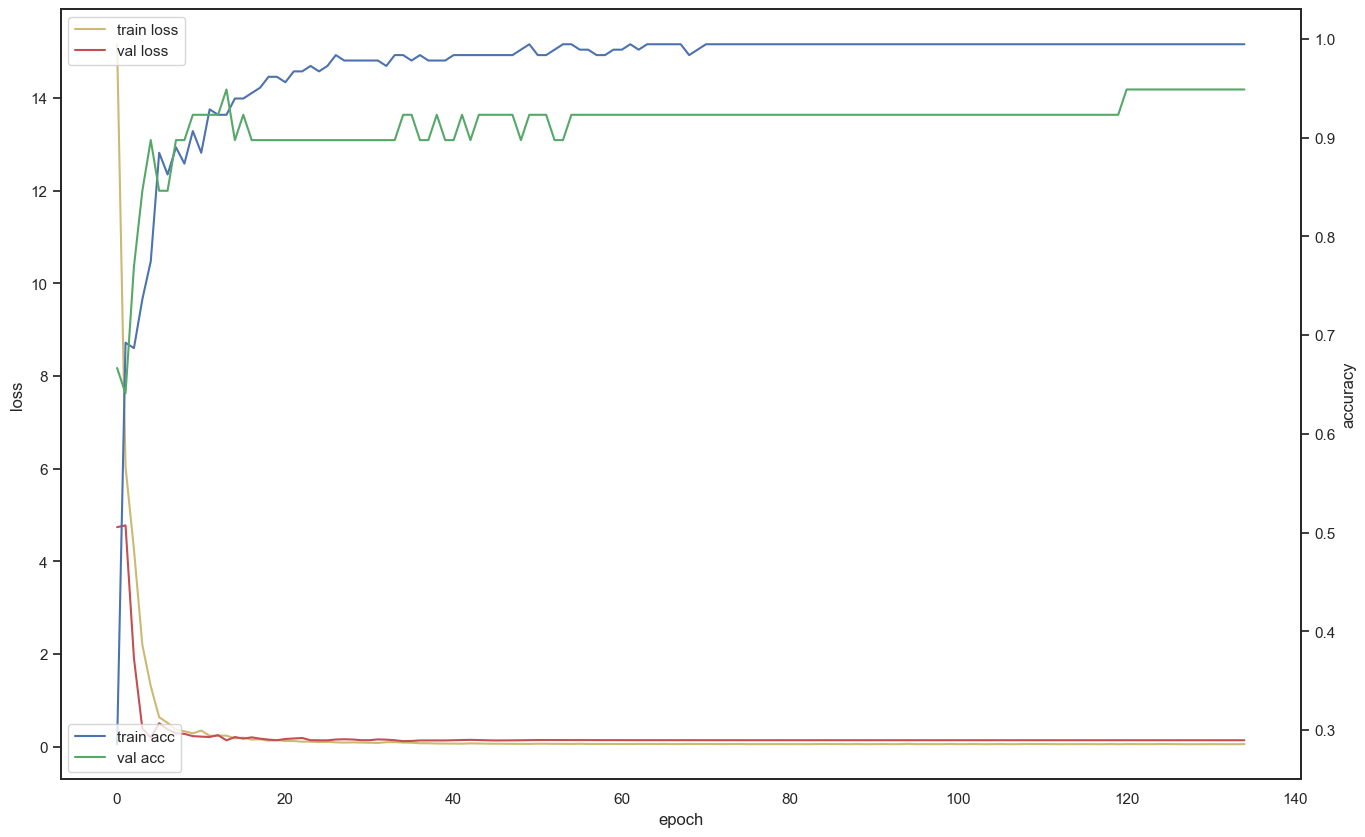

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9725 - loss: 0.0824 
rollfeet
Test Loss: 0.06188514456152916
Test Accuracy: 0.9743589758872986



In [7]:
history = model_fit(model, X_test, y_test, X_val, y_val, behavior, epochs=150)
plot_show(history)

test_loss, test_accuracy = model.evaluate(split_X(X_test), y_test, verbose=1)

print(behavior)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


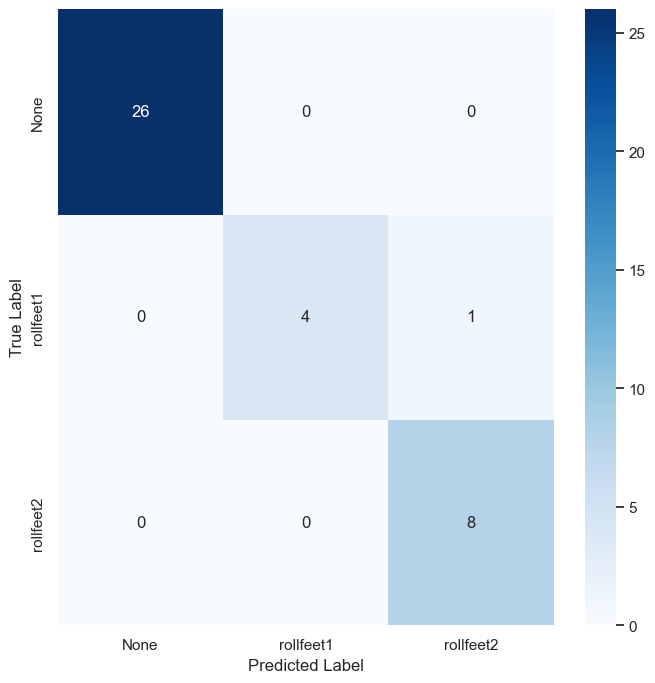

In [8]:
show_confusion_matrix(behavior, model, X_test, y_test)

#### hooray

In [9]:
csv_directory = 'datasets_processing_data_csvs'

behaviors = multimodel.behaviors
str2int = multimodel.str2int

model_version = '_small'
behavior = 'hooray'
mmd = MultiModelDetector(behavior)
num_classes = mmd.num_classes

data = pd.read_csv(os.path.join(csv_directory, f'{behavior}_small_output.csv'))

X = data.drop(['name', 'label'], axis=1)
y = data['label']
y = to_categorical(y, num_classes=num_classes)

# train:val:test = 70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

model = make_model(str2int[behavior])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)   │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_16 (InputLayer)   │ (None, 12)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 28)                │               0 │ input_layer_14[0][0],      │
│                               │                           │                 │ input_layer_16[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 128)               │           3,712 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 64)                │           8,256 │ dense_8[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_10 (Dense)              │ (None, 32)                │           2,080 │ dense_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_12 (InputLayer)   │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_13 (InputLayer)   │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_15 (InputLayer)   │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_17 (InputLayer)   │ (None, 2)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_11 (Dense)              │ (None, 2)                 │              66 │ dense_10[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 14,114 (55.13 KB)

 Trainable params: 14,114 (55.13 KB)

 Non-trainable params: 0 (0.00 B)

기존 모델 파일 'models/hooray_model_small.keras' 삭제됨


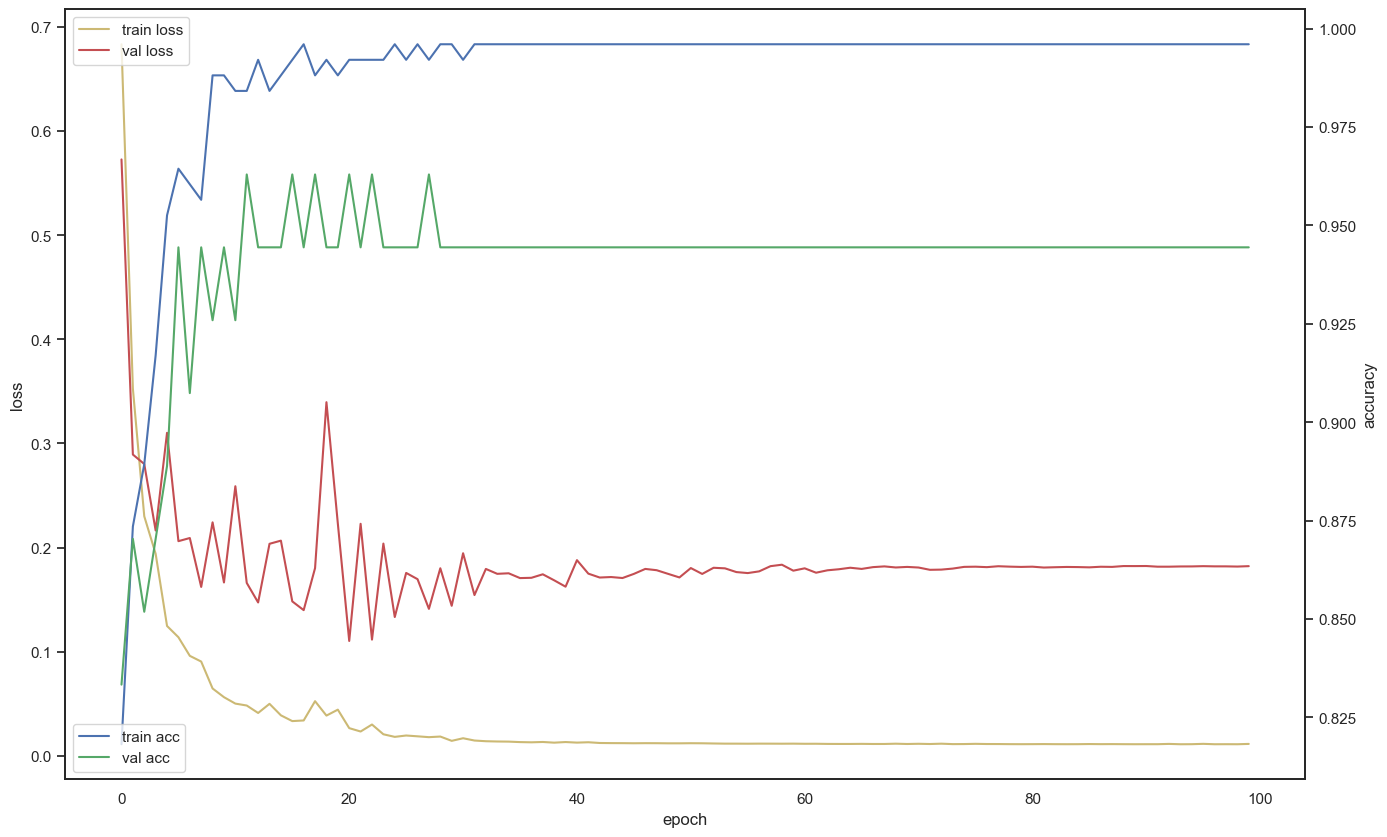

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9636 - loss: 0.1118 
hooray
Test Loss: 0.16419313848018646
Test Accuracy: 0.9454545378684998



In [10]:
history = model_fit(model, X_test, y_test, X_val, y_val, behavior)
plot_show(history)

test_loss, test_accuracy = model.evaluate(split_X(X_test), y_test, verbose=1)

print(behavior)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000163CFD4B880> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


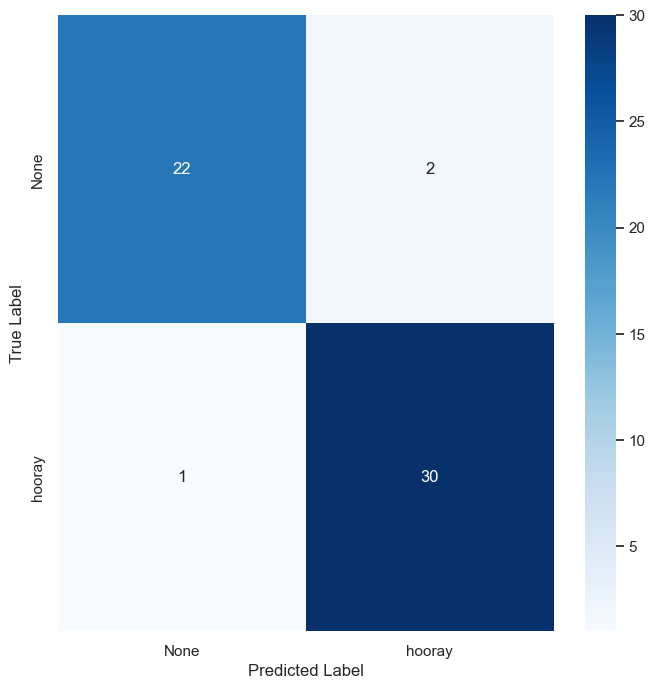

In [11]:
show_confusion_matrix(behavior, model, X_test, y_test)

#### jumpyhooray

In [12]:
csv_directory = 'datasets_processing_data_csvs'

behaviors = multimodel.behaviors
str2int = multimodel.str2int

model_version = '_small'
behavior = 'jumphooray'
mmd = MultiModelDetector(behavior)
num_classes = mmd.num_classes

data = pd.read_csv(os.path.join(csv_directory, f'{behavior}_small_output.csv'))

X = data.drop(['name', 'label'], axis=1)
y = data['label']
y = to_categorical(y, num_classes=num_classes)

# train:val:test = 70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

model = make_model(str2int[behavior])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)   │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_22 (InputLayer)   │ (None, 12)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 28)                │               0 │ input_layer_20[0][0],      │
│                               │                           │                 │ input_layer_22[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 128)               │           3,712 │ concatenate_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_13 (Dense)              │ (None, 64)                │           8,256 │ dense_12[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_14 (Dense)              │ (None, 32)                │           2,080 │ dense_13[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_18 (InputLayer)   │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_19 (InputLayer)   │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_21 (InputLayer)   │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_23 (InputLayer)   │ (None, 2)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_15 (Dense)              │ (None, 3)                 │              99 │ dense_14[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 14,147 (55.26 KB)

 Trainable params: 14,147 (55.26 KB)

 Non-trainable params: 0 (0.00 B)

기존 모델 파일 'models/jumphooray_model_small.keras' 삭제됨


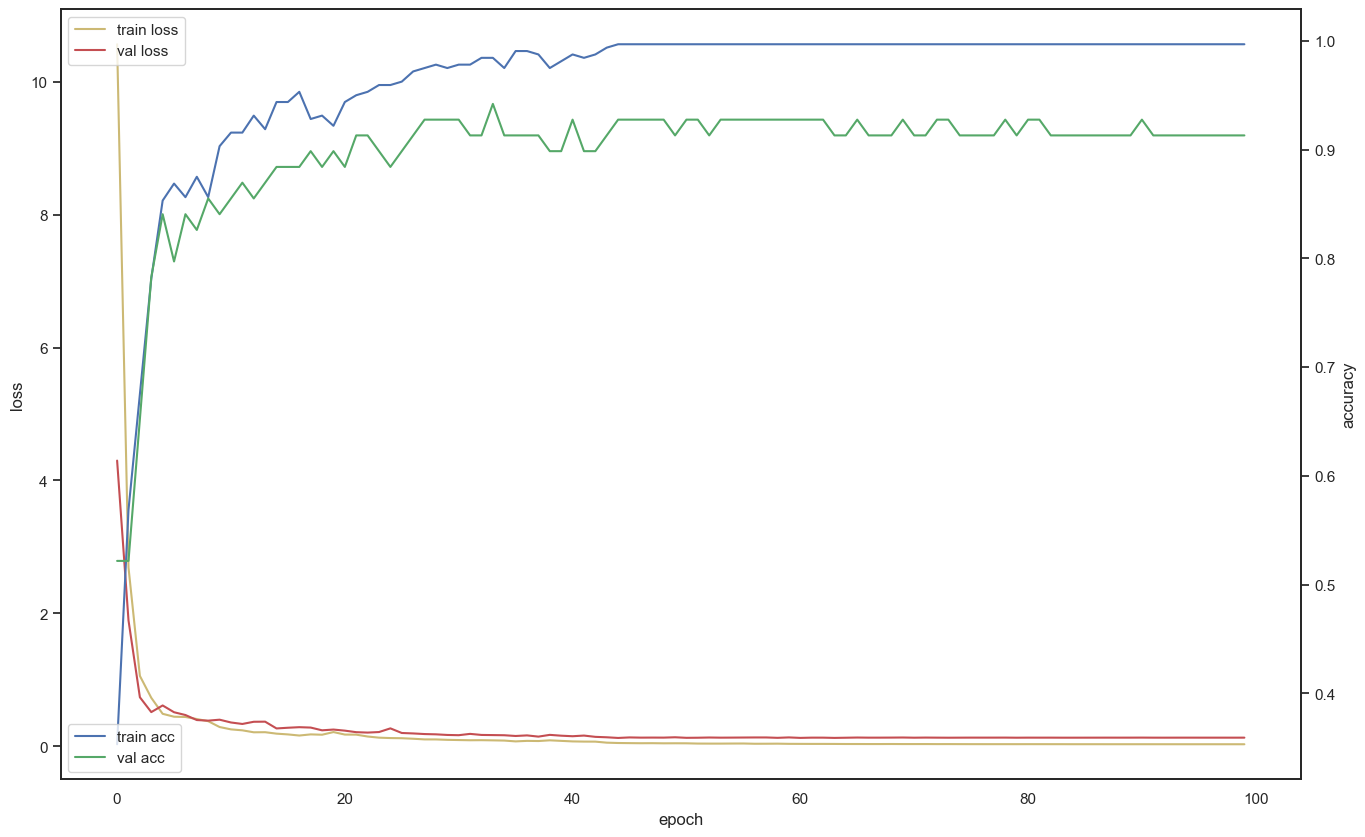

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9208 - loss: 0.2723 
jumphooray
Test Loss: 0.20041720569133759
Test Accuracy: 0.9275362491607666



In [13]:
history = model_fit(model, X_test, y_test, X_val, y_val, behavior)
plot_show(history)

test_loss, test_accuracy = model.evaluate(split_X(X_test), y_test, verbose=1)

print(behavior)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


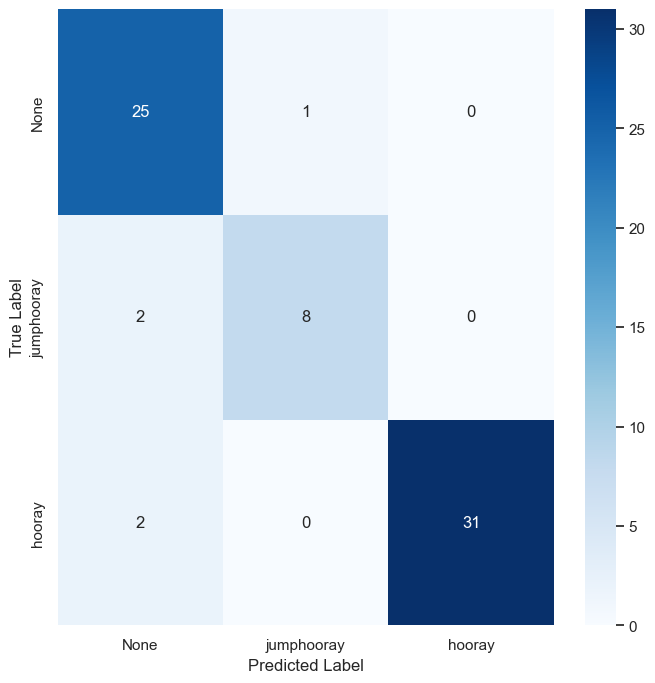

In [14]:
show_confusion_matrix(behavior, model, X_test, y_test)

#### clap

In [3]:
csv_directory = 'datasets_processing_data_csvs'

behaviors = multimodel.behaviors
str2int = multimodel.str2int

model_version = '_small'
behavior = 'clap'
mmd = MultiModelDetector(behavior)
num_classes = mmd.num_classes

data = pd.read_csv(os.path.join(csv_directory, f'{behavior}_small_output.csv'))

X = data.drop(['name', 'label'], axis=1)
y = data['label']
y = to_categorical(y, num_classes=num_classes)

# train:val:test = 70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

model = make_model(str2int[behavior])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_4 (InputLayer)    │ (None, 12)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 28)                │               0 │ input_layer_2[0][0],       │
│                               │                           │                 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │           3,712 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           8,256 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 32)                │           2,080 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer (InputLayer)      │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 2)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 3)                 │              99 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 14,147 (55.26 KB)

 Trainable params: 14,147 (55.26 KB)

 Non-trainable params: 0 (0.00 B)

기존 모델 파일 'models/clap_model_small.keras' 삭제됨


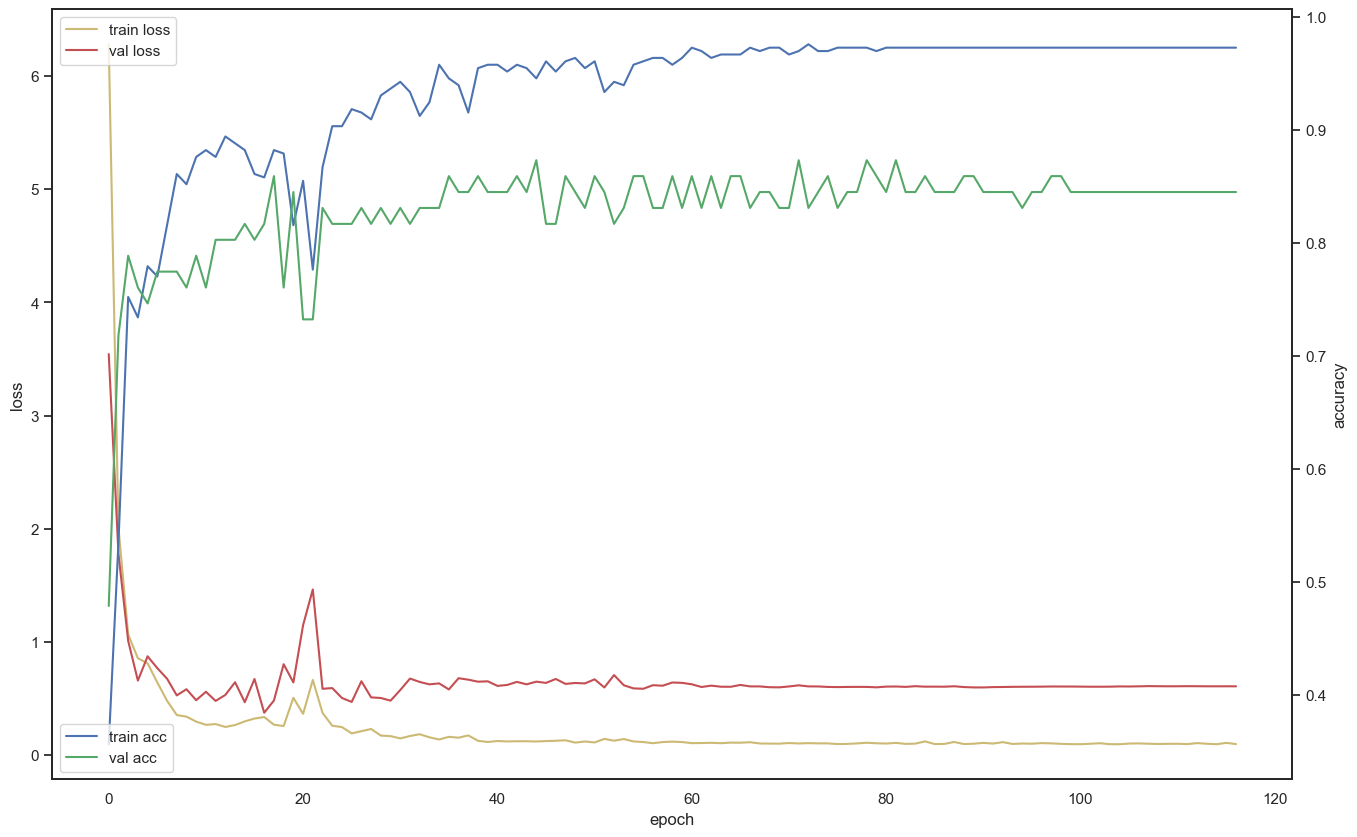

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8789 - loss: 0.2359 
clap
Test Loss: 0.24165260791778564
Test Accuracy: 0.875



In [4]:
history = model_fit(model, X_test, y_test, X_val, y_val, behavior, epochs=150)
plot_show(history)

test_loss, test_accuracy = model.evaluate(split_X(X_test), y_test, verbose=1)

print(behavior)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


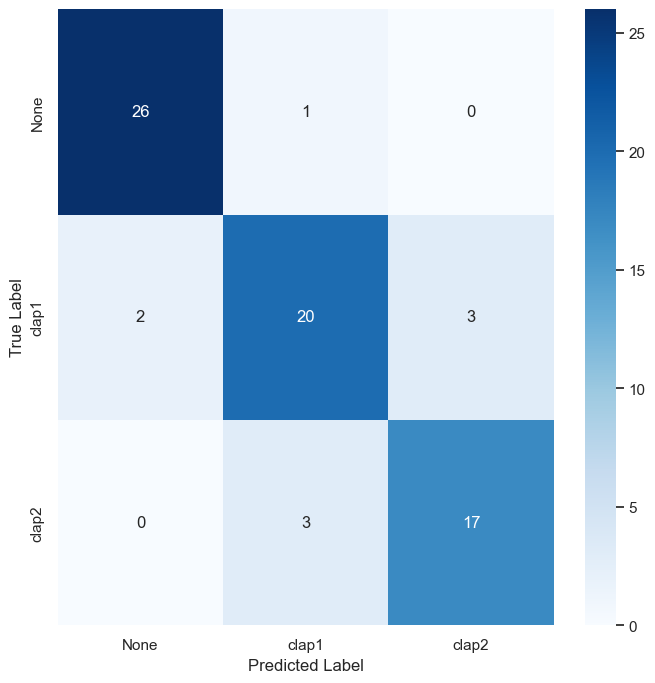

In [5]:
show_confusion_matrix(behavior, model, X_test, y_test)

#### cheek

In [18]:
csv_directory = 'datasets_processing_data_csvs'

behaviors = multimodel.behaviors
str2int = multimodel.str2int

model_version = '_small'
behavior = 'cheek'
mmd = MultiModelDetector(behavior)
num_classes = mmd.num_classes

data = pd.read_csv(os.path.join(csv_directory, f'{behavior}_small_output.csv'))

X = data.drop(['name', 'label'], axis=1)
y = data['label']
y = to_categorical(y, num_classes=num_classes)

# train:val:test = 70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

model = make_model(str2int[behavior])
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)   │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_31 (InputLayer)   │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_33 (InputLayer)   │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_35 (InputLayer)   │ (None, 2)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_5 (Concatenate)   │ (None, 48)                │               0 │ input_layer_30[0][0],      │
│                               │                           │                 │ input_layer_31[0][0],      │
│                               │                           │                 │ input_layer_33[0][0],      │
│                               │                           │                 │ input_layer_35[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_20 (Dense)              │ (None, 128)               │           6,272 │ concatenate_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_21 (Dense)              │ (None, 64)                │           8,256 │ dense_20[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_22 (Dense)              │ (None, 32)                │           2,080 │ dense_21[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_32 (InputLayer)   │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_34 (InputLayer)   │ (None, 12)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_23 (Dense)              │ (None, 3)                 │              99 │ dense_22[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,707 (65.26 KB)

 Trainable params: 16,707 (65.26 KB)

 Non-trainable params: 0 (0.00 B)

기존 모델 파일 'models/cheek_model_small.keras' 삭제됨


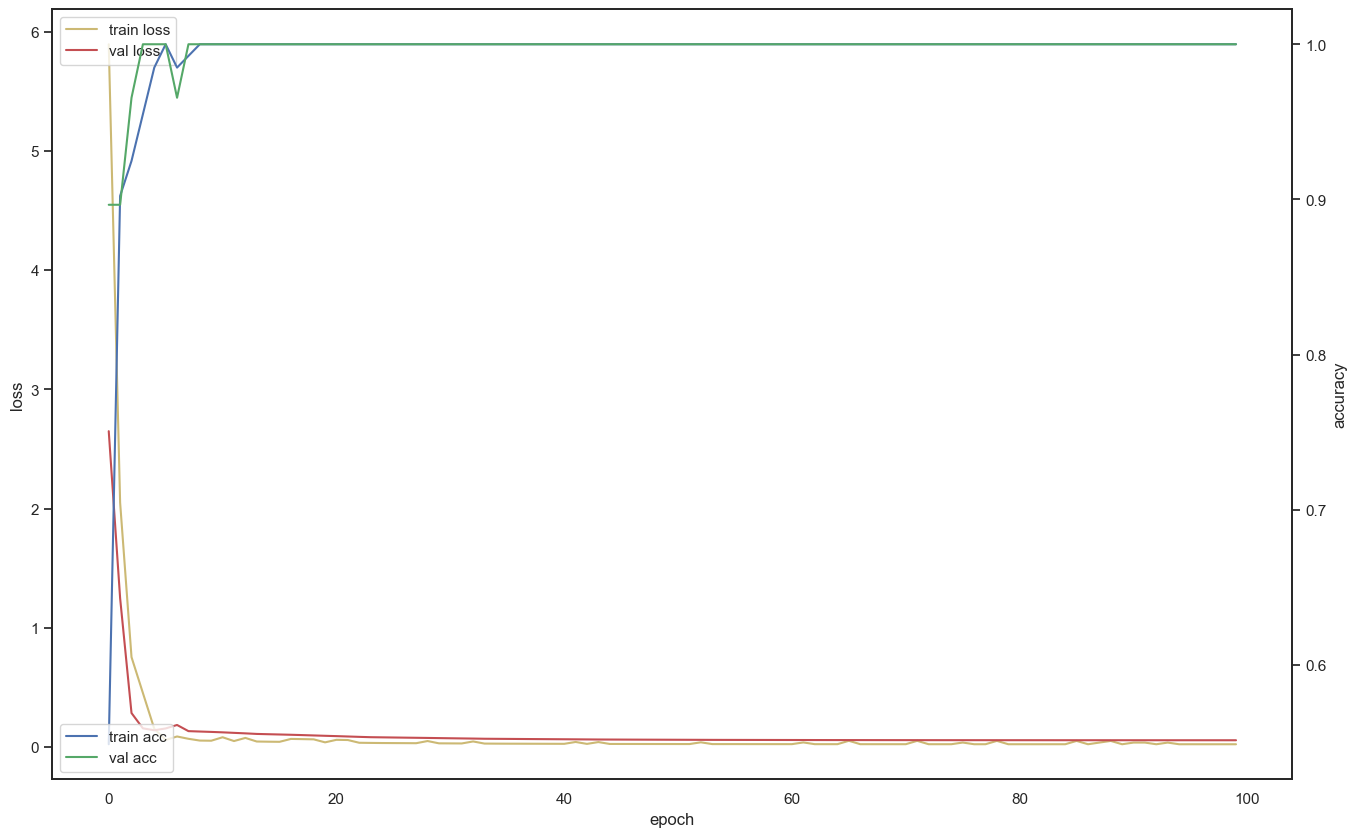

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9655 - loss: 0.0353
cheek
Test Loss: 0.03532159700989723
Test Accuracy: 0.9655172228813171



In [19]:
history = model_fit(model, X_test, y_test, X_val, y_val, behavior)
plot_show(history)

test_loss, test_accuracy = model.evaluate(split_X(X_test), y_test, verbose=1)

print(behavior)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


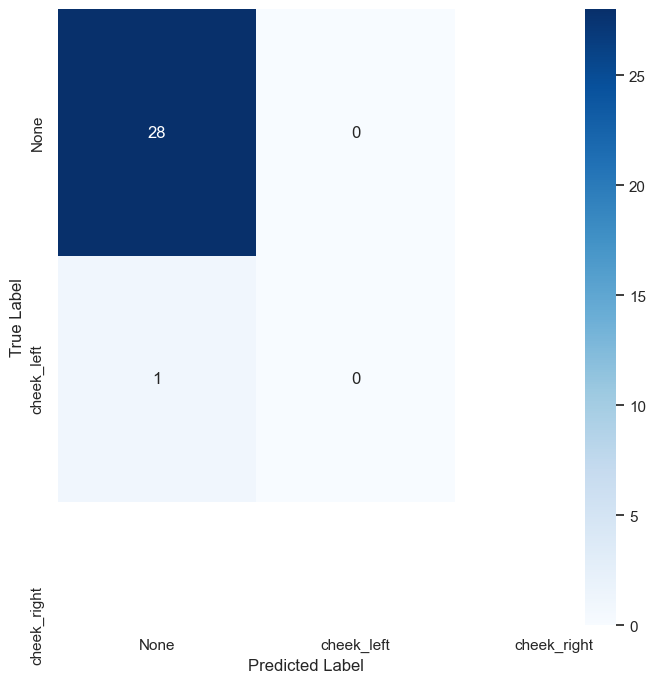

In [20]:
show_confusion_matrix(behavior, model, X_test, y_test)

#### RPS

In [21]:
csv_directory = 'datasets_processing_data_csvs'

behaviors = multimodel.behaviors
str2int = multimodel.str2int

model_version = '_small'
behavior = 'RPS'
mmd = MultiModelDetector(behavior)
num_classes = mmd.num_classes

data = pd.read_csv(os.path.join(csv_directory, f'{behavior}_small_output.csv'))

X = data.drop(['name', 'label'], axis=1)
y = data['label']
y = to_categorical(y, num_classes=num_classes)

# train:val:test = 70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

model = make_model(str2int[behavior])
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)   │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_37 (InputLayer)   │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_6 (Concatenate)   │ (None, 30)                │               0 │ input_layer_36[0][0],      │
│                               │                           │                 │ input_layer_37[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_24 (Dense)              │ (None, 128)               │           3,968 │ concatenate_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_25 (Dense)              │ (None, 64)                │           8,256 │ dense_24[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_26 (Dense)              │ (None, 32)                │           2,080 │ dense_25[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_38 (InputLayer)   │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_39 (InputLayer)   │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_40 (InputLayer)   │ (None, 12)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_41 (InputLayer)   │ (None, 2)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_27 (Dense)              │ (None, 9)                 │             297 │ dense_26[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 14,601 (57.04 KB)

 Trainable params: 14,601 (57.04 KB)

 Non-trainable params: 0 (0.00 B)

기존 모델 파일 'models/RPS_model_small.keras' 삭제됨


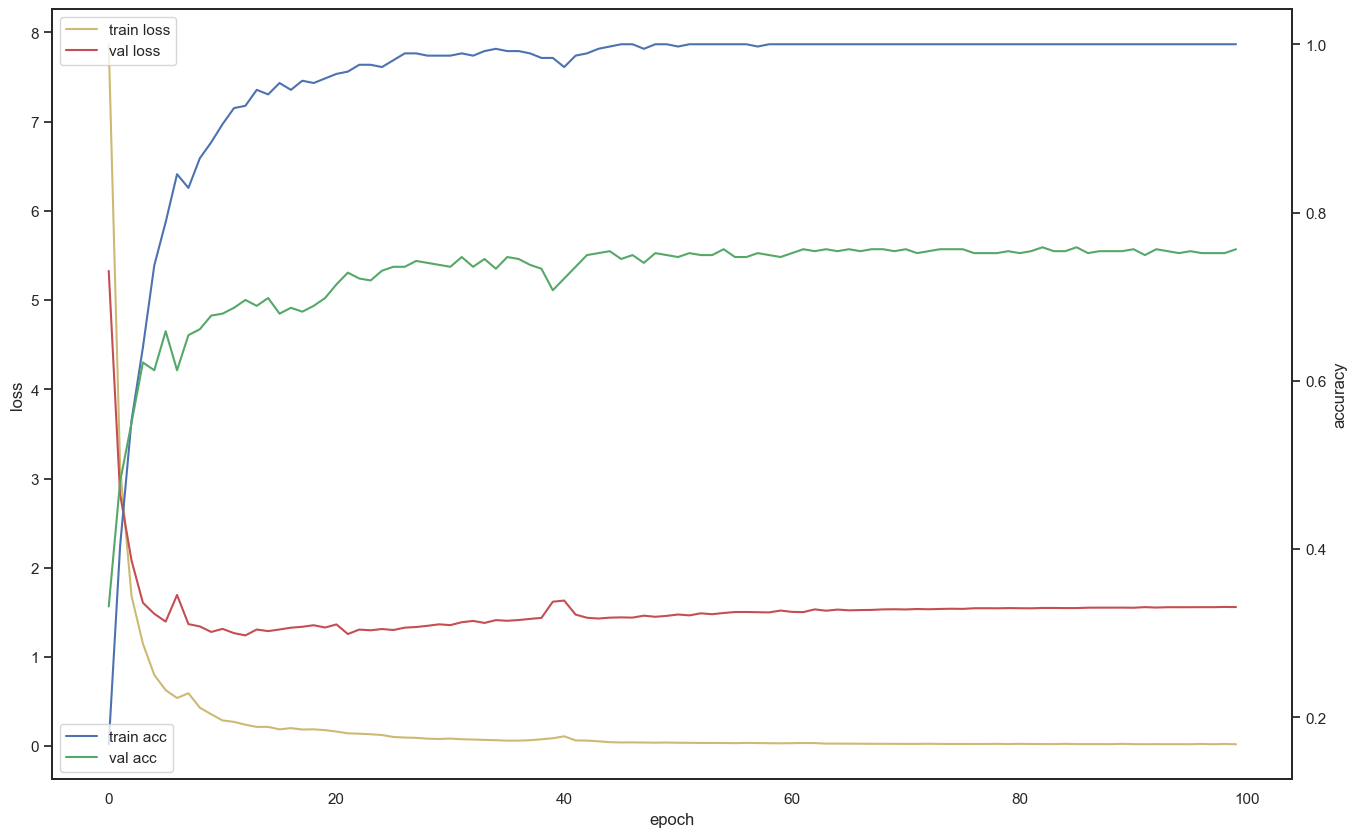

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7284 - loss: 1.4819 
RPS
Test Loss: 1.4807144403457642
Test Accuracy: 0.7337962985038757



In [22]:
history = model_fit(model, X_test, y_test, X_val, y_val, behavior)
plot_show(history)

test_loss, test_accuracy = model.evaluate(split_X(X_test), y_test, verbose=1)

print(behavior)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


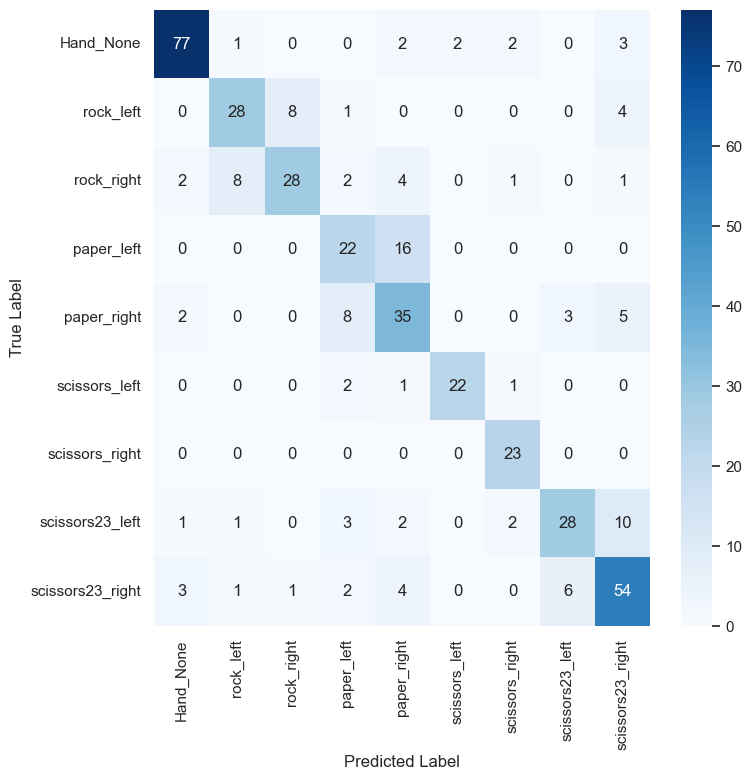

In [23]:
show_confusion_matrix(behavior, model, X_test, y_test)

#### thumbsup

In [24]:
csv_directory = 'datasets_processing_data_csvs'

behaviors = multimodel.behaviors
str2int = multimodel.str2int

model_version = '_small'
behavior = 'thumbsup'
mmd = MultiModelDetector(behavior)
num_classes = mmd.num_classes

data = pd.read_csv(os.path.join(csv_directory, f'{behavior}_small_output.csv'))

X = data.drop(['name', 'label'], axis=1)
y = data['label']
y = to_categorical(y, num_classes=num_classes)

# train:val:test = 70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

model = make_model(str2int[behavior])
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)   │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_43 (InputLayer)   │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_7 (Concatenate)   │ (None, 30)                │               0 │ input_layer_42[0][0],      │
│                               │                           │                 │ input_layer_43[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_28 (Dense)              │ (None, 128)               │           3,968 │ concatenate_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_29 (Dense)              │ (None, 64)                │           8,256 │ dense_28[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_30 (Dense)              │ (None, 32)                │           2,080 │ dense_29[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_44 (InputLayer)   │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_45 (InputLayer)   │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_46 (InputLayer)   │ (None, 12)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_47 (InputLayer)   │ (None, 2)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_31 (Dense)              │ (None, 4)                 │             132 │ dense_30[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 14,436 (56.39 KB)

 Trainable params: 14,436 (56.39 KB)

 Non-trainable params: 0 (0.00 B)

기존 모델 파일 'models/thumbsup_model_small.keras' 삭제됨


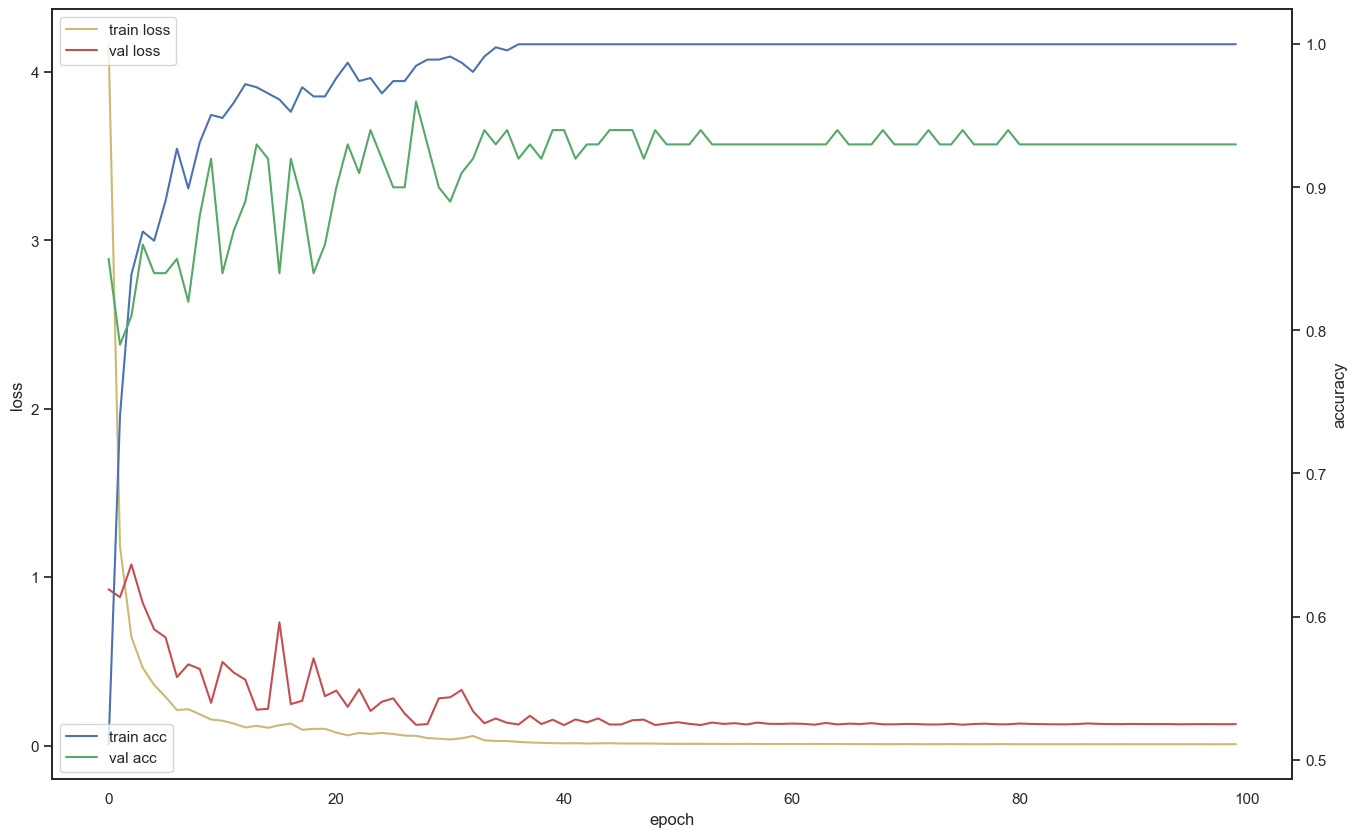

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9255 - loss: 0.3916 
thumbsup
Test Loss: 0.618977427482605
Test Accuracy: 0.9100000262260437



In [25]:
history = model_fit(model, X_test, y_test, X_val, y_val, behavior)
plot_show(history)

test_loss, test_accuracy = model.evaluate(split_X(X_test), y_test, verbose=1)

print(behavior)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


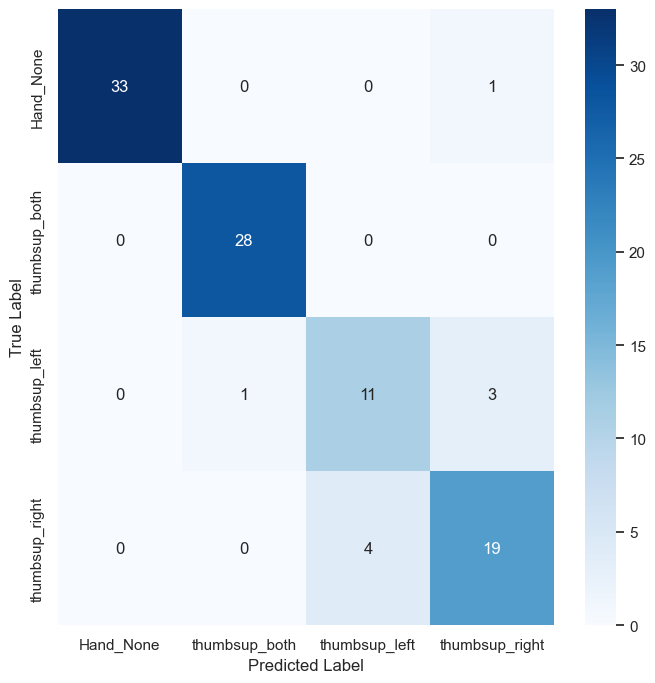

In [26]:
show_confusion_matrix(behavior, model, X_test, y_test)

#### all

In [27]:
csv_directory = 'datasets_processing_data_csvs'

behaviors = multimodel.behaviors
str2int = multimodel.str2int

model_version == '_small'
behavior = 'all'
mmd = MultiModelDetector(behavior)
num_classes = mmd.num_classes

data = pd.read_csv(os.path.join(csv_directory, f'{behavior}_small_output.csv'))

X = data.drop(['name', 'label'], axis=1)
y = data['label']
y = to_categorical(y, num_classes=num_classes)

# train:val:test = 70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

model = make_model(str2int[behavior])
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)   │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_49 (InputLayer)   │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_50 (InputLayer)   │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_51 (InputLayer)   │ (None, 16)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_52 (InputLayer)   │ (None, 12)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_8 (Concatenate)   │ (None, 74)                │               0 │ input_layer_48[0][0],      │
│                               │                           │                 │ input_layer_49[0][0],      │
│                               │                           │                 │ input_layer_50[0][0],      │
│                               │                           │                 │ input_layer_51[0][0],      │
│                               │                           │                 │ input_layer_52[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_32 (Dense)              │ (None, 128)               │           9,600 │ concatenate_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_33 (Dense)              │ (None, 64)                │           8,256 │ dense_32[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_34 (Dense)              │ (None, 32)                │           2,080 │ dense_33[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_53 (InputLayer)   │ (None, 2)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_35 (Dense)              │ (None, 22)                │             726 │ dense_34[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 20,662 (80.71 KB)

 Trainable params: 20,662 (80.71 KB)

 Non-trainable params: 0 (0.00 B)

기존 모델 파일 'models/all_model_small.keras' 삭제됨


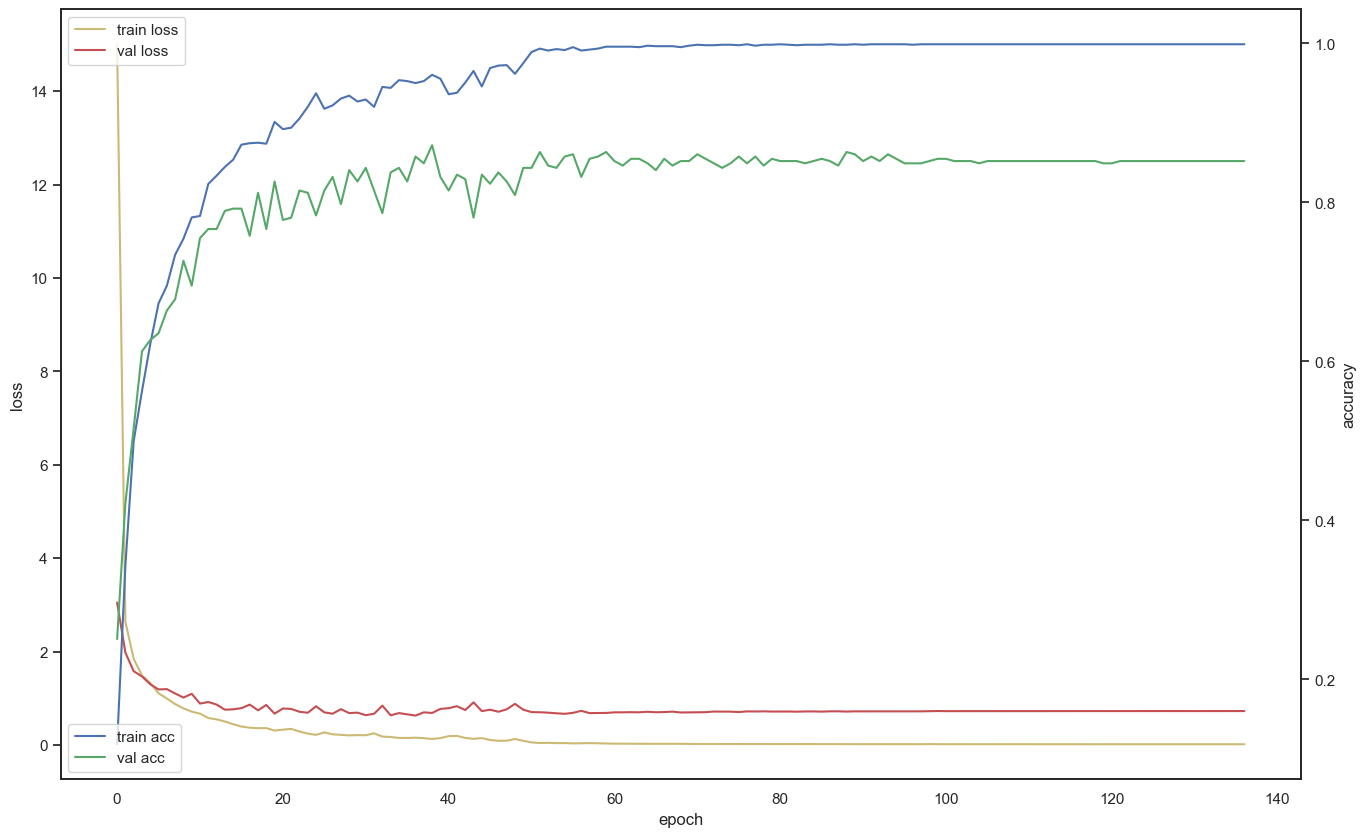

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.8621 - loss: 0.7408
all
Test Loss: 0.7867910265922546
Test Accuracy: 0.8522727489471436



In [28]:
history = model_fit(model, X_test, y_test, X_val, y_val, behavior, epochs=300)
plot_show(history)

test_loss, test_accuracy = model.evaluate(split_X(X_test), y_test, verbose=1)

print(behavior)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


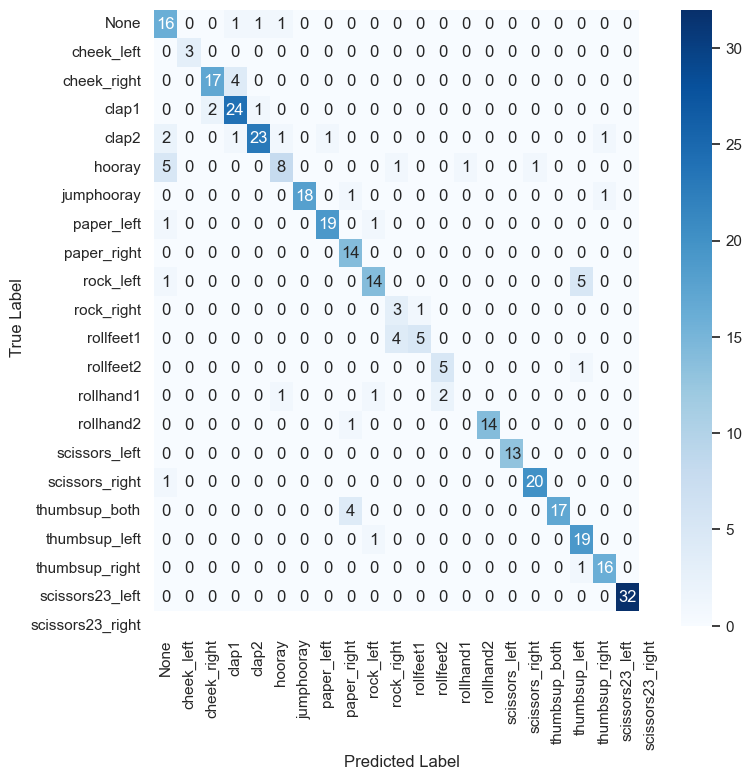

In [29]:
show_confusion_matrix(behavior, model, X_test, y_test)